In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import IPython.display as display
import PIL.Image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

RGB_MEAN = [103.939/255, 116.779/255, 123.68/255]

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

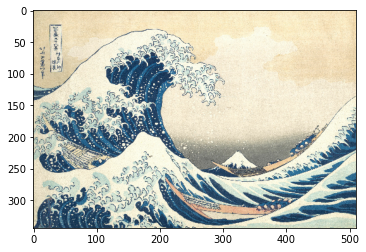

In [2]:
# Importing Images

# painting = load_img('Art/paintings/the_weeping_woman.png')
# painting = load_img('Art/paintings/the_starry_night.jpg')
painting = load_img('Art/paintings/the_great_wave_off_kanagawa.jpg')
# painting = load_img('Art/paintings/the_storm_on_the_sea_of_galilee.png')
# painting = load_img('Art/paintings/wanderer_above_the_sea_of_fog.jpg')
# painting = load_img('Art/paintings/the_scream.jpg')
# painting = load_img('Art/paintings/mars.png')

image = load_img('Art/images/greece.jpg')
# image = load_img('Art/images/earth.jpg')
# image = load_img('Art/images/uni.jpeg')
# image = load_img('Art/images/taj.jpg')
# image = load_img('Art/images/sskp.jpg')
# image = load_img('Art/images/rr.png')
# image = load_img('Art/images/cereal.png')


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    

imshow(painting)

### Importing the Oxford VGG model

In [3]:

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Preprocessing images

In [4]:
ppd_image = image - RGB_MEAN

ppd_painting = painting - RGB_MEAN

In [5]:
vgg.trainable = False

# Selecting the layers used in the paper
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Making the model
model_layers = [vgg.get_layer(layer_name).output for layer_name in style_layers]
model_layers.append(vgg.get_layer(content_layers[0]).output)

model = tf.keras.Model([vgg.input], model_layers)
model.trainable = False

In [7]:
# Calculating gram matrix of feature maps
def gram_matrix(feature_map):
    return tf.linalg.einsum('bijc,bijd->bcd', feature_map, feature_map)

def get_style_content(outputs):
    """
    Args:
        ouputs: output given by model
    Returns:
        A tuple containing separated (content, style) of image
    """
    return ([gram_matrix(output) for output in outputs[:-1]],
            outputs[-1:])

In [8]:
image_outputs = model(ppd_image)
_ , target_content = get_style_content(image_outputs)

painting_outputs = model(ppd_painting)
target_style, _ = get_style_content(painting_outputs)

In [18]:
# Style and content weights
style_weight=1e-2
content_weight=1e7

# Using adam as optimizer
opt = tf.optimizers.Adam(learning_rate=0.02)

# Final loss function
def total_loss(out):
    final_style, final_content = get_style_content(out)
    style_loss = tf.add_n([tf.reduce_mean((fs  - ts)**2)
                    for fs, ts in zip(final_style, target_style)])

    content_loss = tf.add_n([tf.reduce_mean((fc - tc)**2)
                    for fc, tc in zip(final_content, target_content)])

    loss = (content_weight*content_loss) + (style_weight*style_loss)
    return loss

In [19]:
# One interation function
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # feeding image in model
        final_out = model(image)

        # calculating loss
        loss = total_loss(final_out)

    # Calculating gradient
    grad = tape.gradient(loss, image)

    # Applying gradient descent
    opt.apply_gradients([(grad, image)])

    # Remapping all img pixel vals between 0.0 & 1.0
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [20]:
# converting arr to image
def arr_to_image(arr):
  arr = arr*255
  arr = np.array(arr, dtype=np.uint8)
  if np.ndim(arr)>3:
    assert arr.shape[0] == 1
    arr = arr[0]
  return PIL.Image.fromarray(arr)

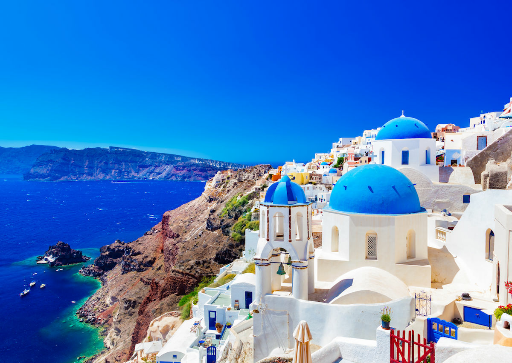

In [21]:
# Displaying image before final processing
arr_to_image(image)

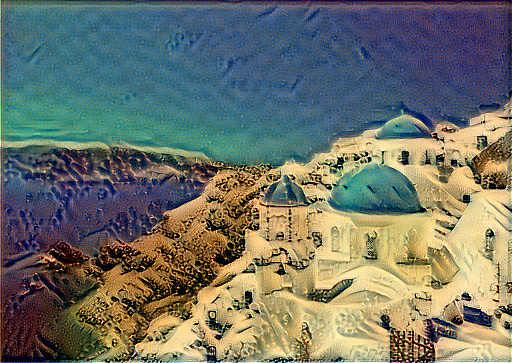

Train step: 60


In [22]:
im = tf.Variable(image)

epochs = 1
steps_per_epoch = 60

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(im)
  display.clear_output(wait=True)
  display.display(arr_to_image(im))
  print("Train step: {}".format(step))

In [23]:
arr_to_image(im).save('greece_scream.png', format='png')